In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import *

from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

### Data Generation:

In [2]:
#Generate some data to be classified. Following qiskit tutorial, training, testing and extra data(prediction)
#samples are created:
def generate_data(ndata=3,title="2D Gaussian data"):
    mean = np.array([1,3])
    cov = np.array([[5,0],[0,3]])
    xa, ya = np.random.default_rng().multivariate_normal(mean, cov, ndata).T

    plt.plot(xa, ya, 'o',color='red',label='A:0')
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')

    mean = np.array([0,4])
    cov = np.array([[4,0],[0,4]])
    xb, yb = np.random.default_rng().multivariate_normal(mean, cov, ndata).T

    plt.plot(xb, yb, 'o',color='blue',label='B:1')
    plt.legend()
    plt.title(title)
    plt.show()
    sample_a = np.column_stack((xa, ya))
    sample_b = np.column_stack((xb,yb))
    sample_dict = {'A':sample_a,'B':sample_b}
    return sample_dict

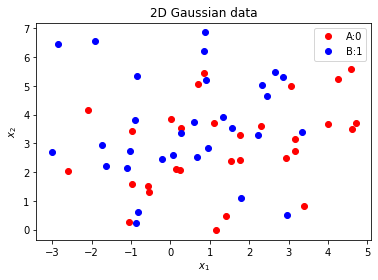

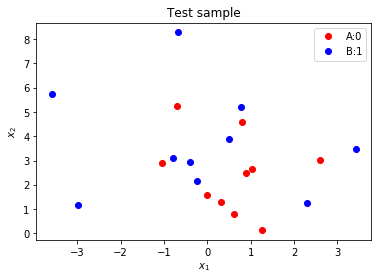

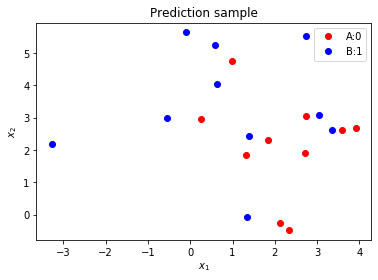

In [3]:
training_input = generate_data(ndata=30)
test_input = generate_data(ndata=10,title='Test sample')
prediction = generate_data(ndata=10,title='Prediction sample')

In [4]:
class_to_label = {'A': 0, 'B': 1}
data_predict = np.vstack((prediction['A'],prediction['B']))
data_labels = np.hstack((np.zeros(prediction['A'].shape[0]),np.ones(prediction['B'].shape[0])))
datapoints = [data_predict,data_labels] #datapoints for the final prediction demonstration

### Feature Map - Data embedding 

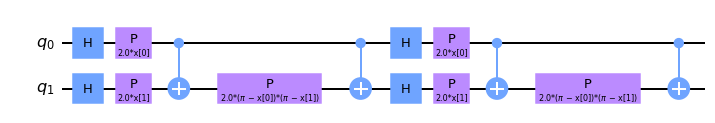

In [5]:
feature_dim=2
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2,entanglement='linear')#From the 3 data embeding circuits that qiskit has
feature_map.draw(output='mpl')

### State vector simulation

In [10]:
backend_ideal = Aer.get_backend('statevector_simulator')
quantum_instance_ideal = QuantumInstance(backend_ideal)
qsvm_ideal = QSVM(feature_map, training_input, test_input, datapoints[0])#qsvm object initialisation

In [9]:
result_ideal = qsvm_ideal.run(quantum_instance_ideal)

print("testing success ratio: {}".format(result_ideal['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm_ideal.label_to_class)))
print("prediction:   {}".format(result_ideal['predicted_classes']))


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 60, constraints m = 61
          nnz(P) + nnz(A) = 1950
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -8.1581e+02   4.23e-04   1.82e+00   1.00e-01   7.55e-04s
  25  -1.0000e+30   7.55e-09   1.54e+00   1.00e-01   1.53e-03s

status:               dual infeasible
number 

ValueError: cannot reshape array of size 1 into shape (60,1)

### Qasm simulation:

In [223]:
seed = 10598
backend_sim = Aer.get_backend('qasm_simulator')
quantum_instance_sim = QuantumInstance(backend_sim, shots=2000, seed_simulator=seed, seed_transpiler=seed)
qsvm_sim = QSVM(feature_map,training_input, test_input, datapoints[0])#qsvm object initialisation

In [224]:
result_sim = qsvm_sim.run(quantum_instance_sim)

print("testing success ratio: {}".format(result_sim['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm_sim.label_to_class)))
print("prediction:   {}".format(result_sim['predicted_classes']))

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 30, constraints m = 31
          nnz(P) + nnz(A) = 525
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.4165e-01   2.46e-01   6.39e-02   1.00e-01   4.41e-04s
 100  -9.2633e-01   1.44e-05   4.24e-06   1.00e-01   1.20e-03s
plsh  -9.2632e-01   5.32e-15   8.85e-15   -----

### Compute kernel matrix and check for positiveness

In [225]:
def is_pos_def(A):
    if np.array_equal(A, A.T):
        print("is sym.")
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        print("is not sym.")
        return False

In [226]:
kernel_matrix_ideal = result_ideal['kernel_matrix_training']
is_pos_def(kernel_matrix_ideal)

is sym.


False

In [227]:
kernel_matrix_sim = result_sim['kernel_matrix_training']
is_pos_def(kernel_matrix_sim)
np.linalg.cholesky(kernel_matrix_sim)

is not sym.


LinAlgError: Matrix is not positive definite

In [228]:
print(np.sort((np.abs(kematrix_sim-kmatrix_sim.T))[np.nonzero(kmatrix_sim-kmatrix_sim.T)])[-1])

NameError: name 'kematrix_sim' is not defined